# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [2]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [3]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [4]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

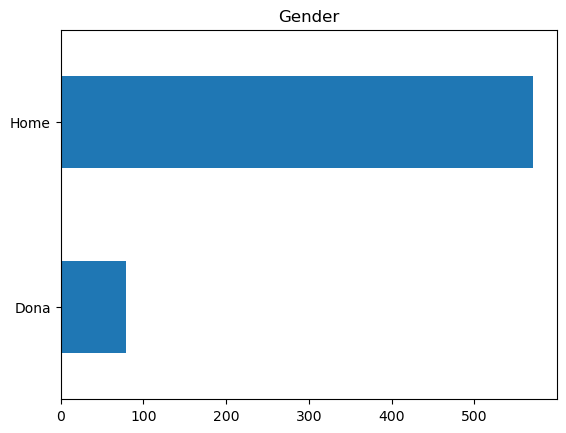

In [5]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

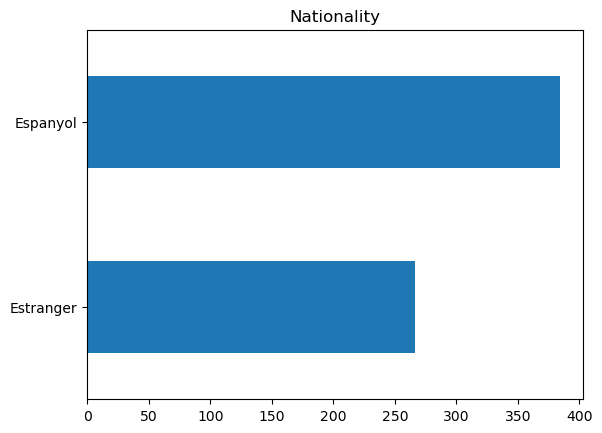

In [6]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

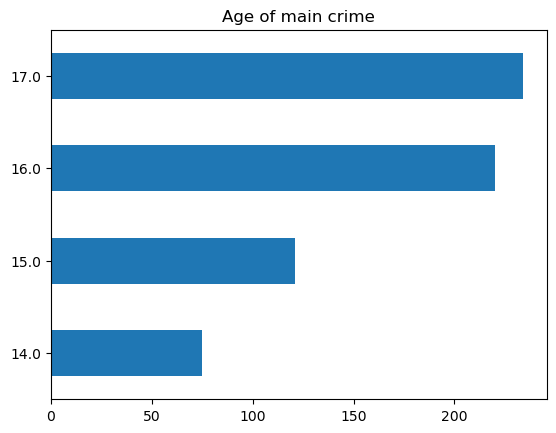

In [7]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

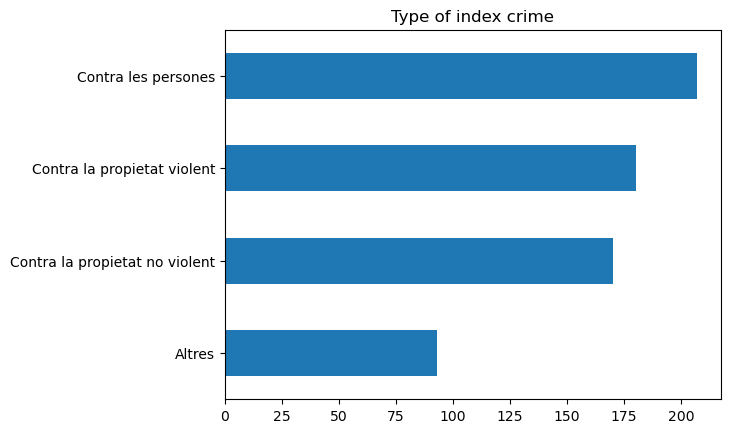

In [8]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.
<a id='humanexpert'></a>

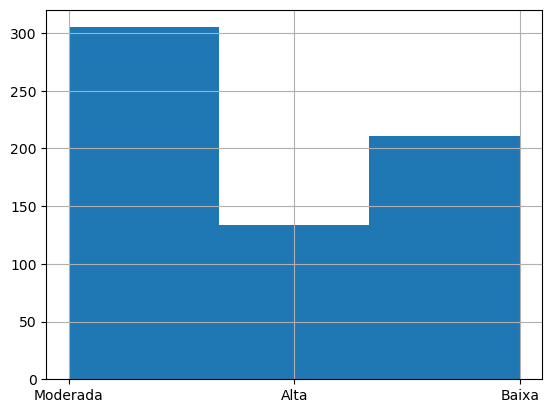

In [9]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

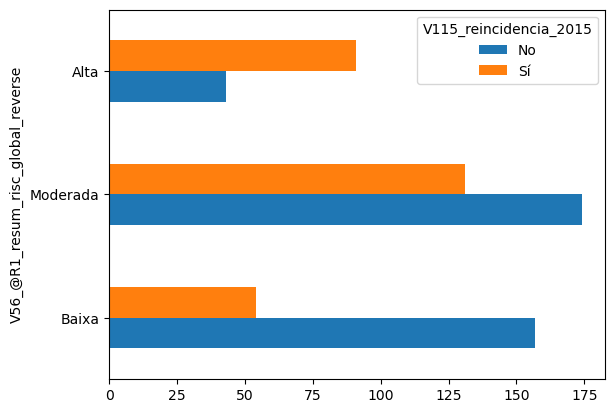

In [10]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [11]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [12]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [13]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

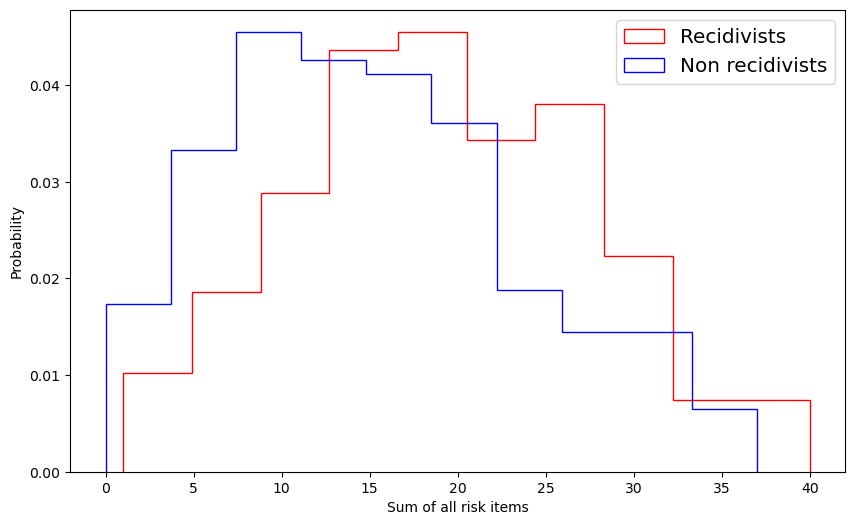

In [14]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [15]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

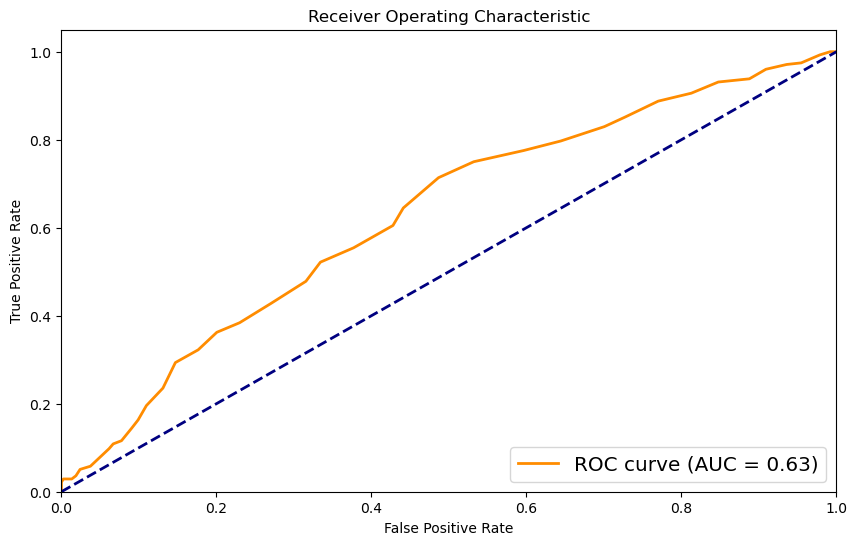

In [16]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [17]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [18]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [19]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [20]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

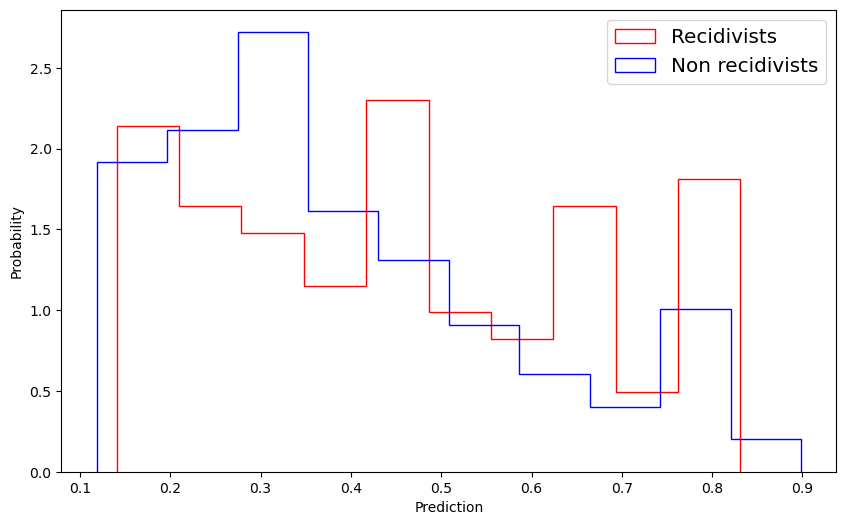

In [21]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

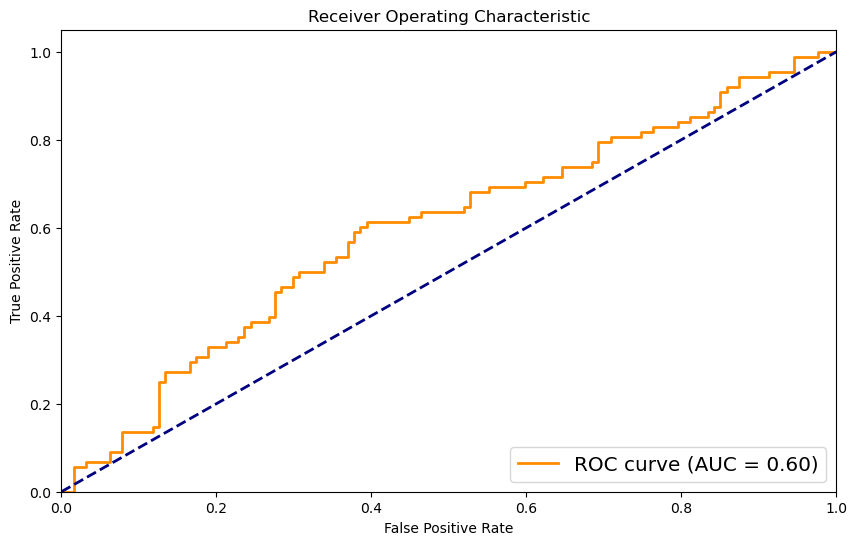

In [22]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [23]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [24]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [25]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

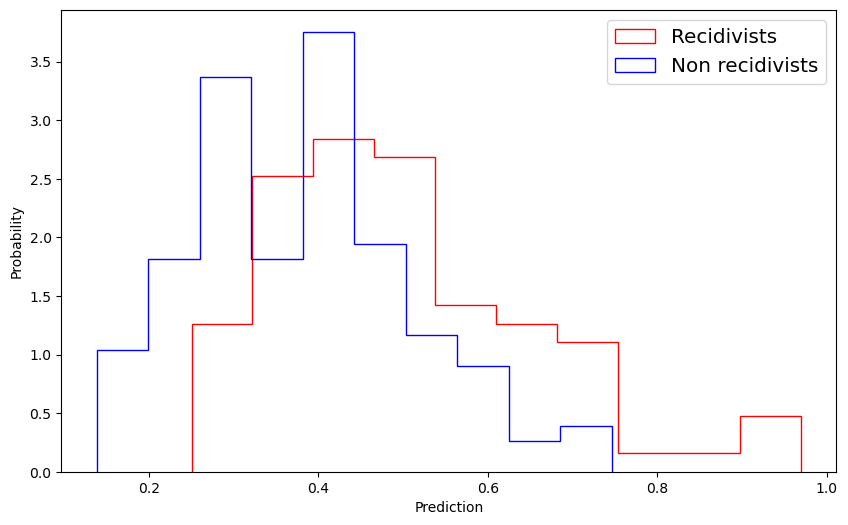

In [26]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

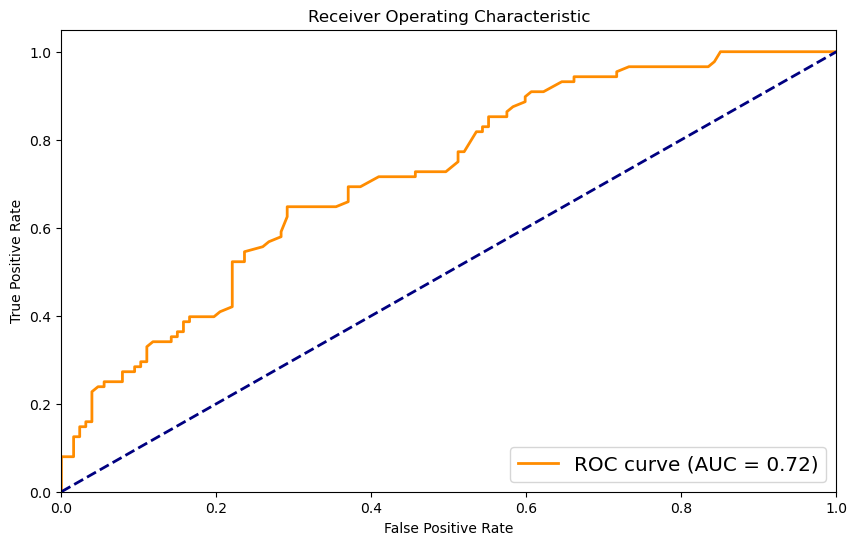

In [27]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [28]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [29]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [30]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

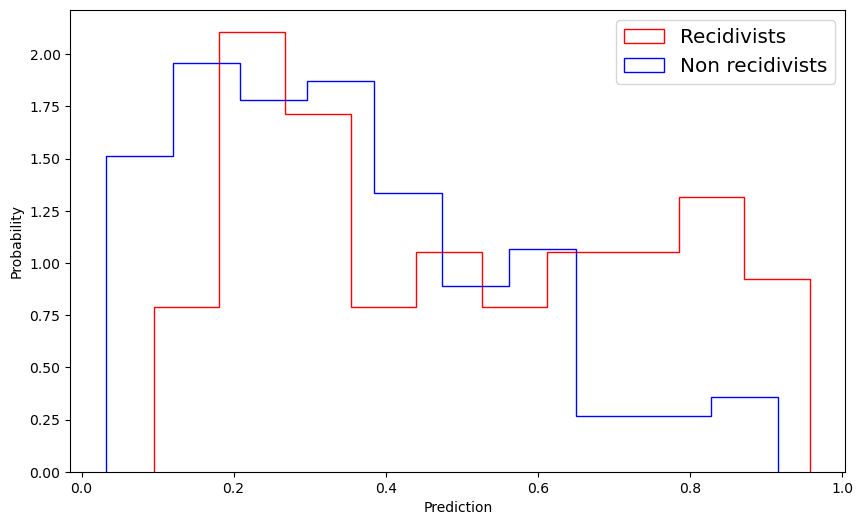

In [31]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

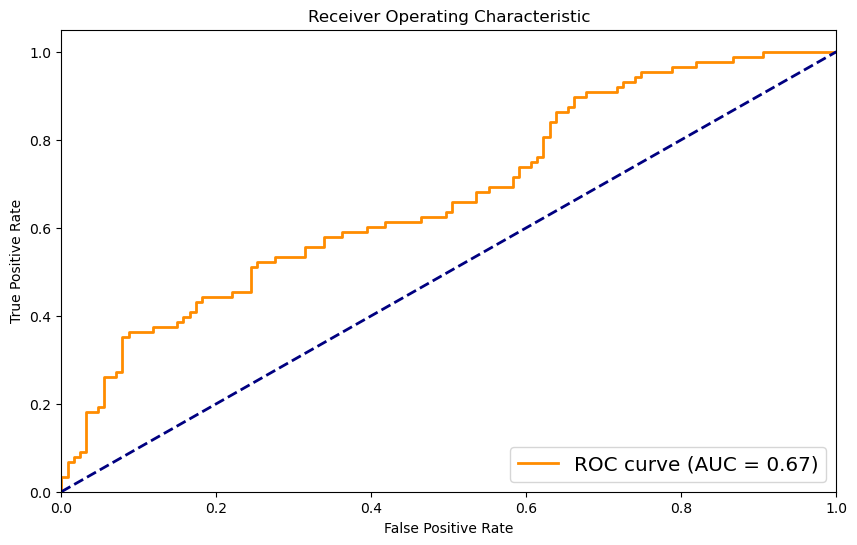

In [32]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [33]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [34]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [35]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [36]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [37]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 19.12
Average SAVRY score of women non-recidivist: 15.67


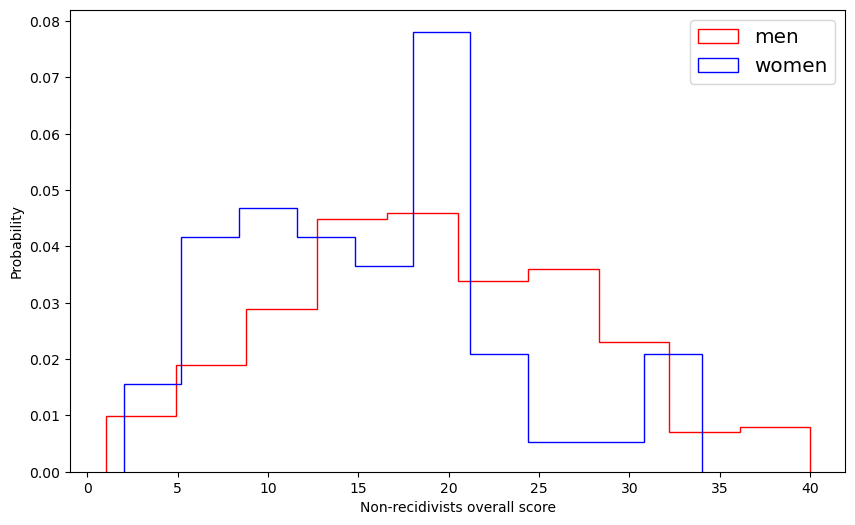

In [38]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [39]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


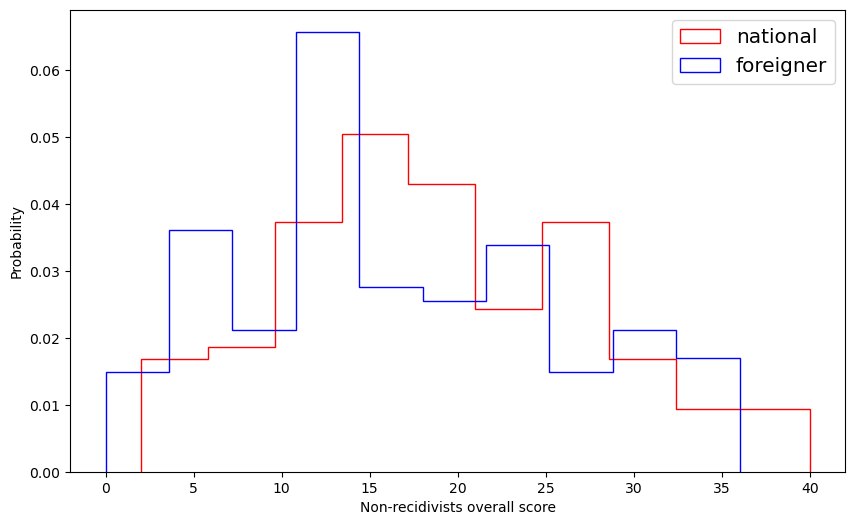

In [40]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score
<a id='baselinefair1'></a>

In [41]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.42
Average predicted probability of women non-recidivist: 0.26


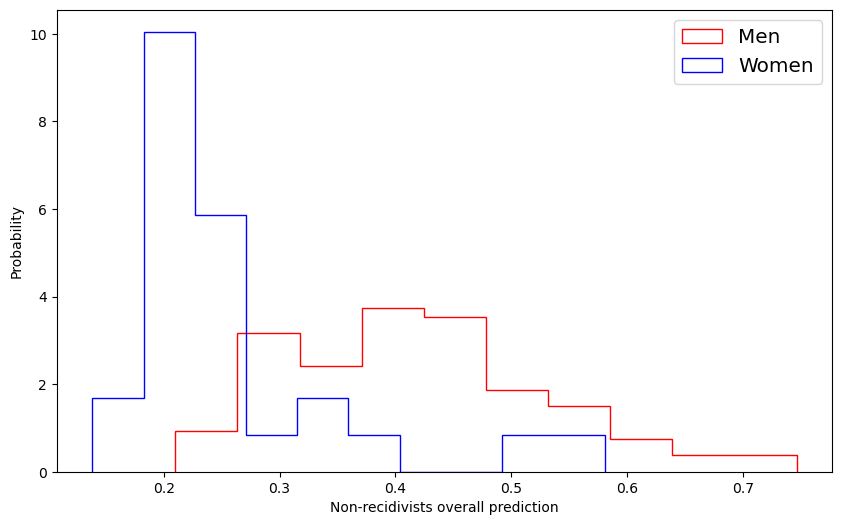

In [42]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [43]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.35
Average predicted probability of foreigner non-recidivist: 0.44


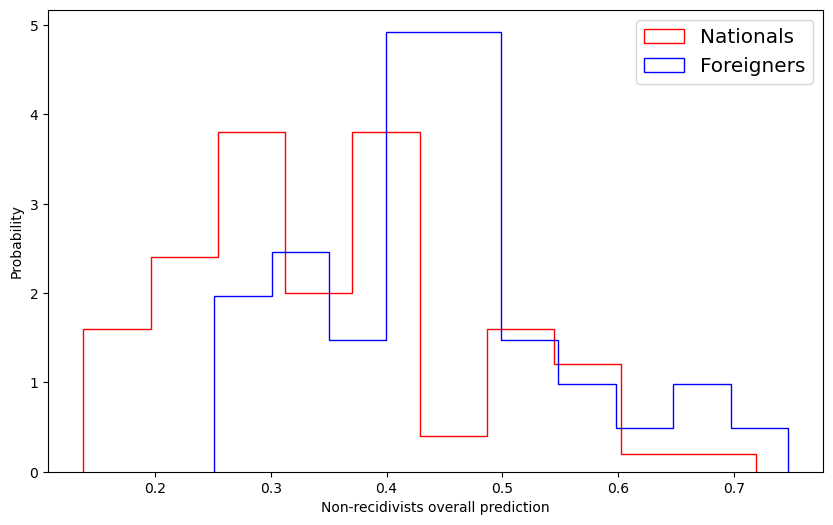

In [44]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



<div class="alert" style="padding: 20px;background-color: #2cbc85; color: white; margin-bottom: 15px; font-size:20px">
SOLUTION EXERCISE 1
</div>

Let us solve Exercise 1. Let us start by using different ML models to check if we can increase the performance of the logistic regression model. Let us try Random Forest, SVM, Decision Tree, K-Nearest Neighbors, AdaBoost, GradientBoosting and Naive Bayes with some hyperparameter tuning.

In [45]:
# Necessary imports
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Let us start by defining the hyperparameters to tune for each classifier.

In [46]:
# Define hyperparameters to tune for each classifier
rf_param_grid = {'n_estimators': [10, 50, 100, 200],
                'max_depth': [None, 1, 2, 3, 4, 5],
                'max_features': ['auto', 'sqrt', 'log2']}
                    
svm_param_grid = {'C': [0.1, 1, 10],
                  'kernel': ['linear', 'poly', 'rbf'],
                  'gamma': [0.1, 0.01,1, 'scale']}
                    
                    
dt_param_grid = {'max_depth': [2, 3, 4, 5],
                 'min_samples_leaf': [1, 2, 3, 4, 5],
                 'min_samples_split': [2, 3, 4, 5]}

knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
                 'weights': ['uniform', 'distance'], 
                 'p': [1, 2]}


aboost_param_grid = {'n_estimators': [50, 100, 200],
                 'learning_rate': [0.01, 0.1, 1.0]}

gboosting_param_grid = {'learning_rate': [0.1, 0.05, 0.01],
                      'n_estimators': [100, 500, 1000],
                      'max_depth': [3, 4, 5]}

nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


Now, let us create a dictionary of the classifiers we are going to use and the parameter grid. Finally, we will fit and store our model for future use.

In [47]:
# Create dictionary of classifiers and their parameter grids
classifiers = {'Random Forest': (RandomForestClassifier(random_state = 42), rf_param_grid),
               'Support Vector Machine': (SVC(random_state = 42,probability=True), svm_param_grid),
               'Decision Tree': (DecisionTreeClassifier(random_state = 42), dt_param_grid),
               'K-Nearest Neighbors': (KNeighborsClassifier(), knn_param_grid),
               'AdaBoost': (AdaBoostClassifier(random_state = 42), aboost_param_grid),
               'GradientBoosting' : (GradientBoostingClassifier(random_state = 42), gboosting_param_grid),
               'Naive Bayes': (GaussianNB(), nb_param_grid)}

print('Finding the best parameters to each model...\n')
# Empty dictionary to store the final results
final_results = {}
# Train and store the best classifier for each model
for name, (model, param_grid) in classifiers.items():
    print('\n')
    # Grid search
    grid_search = GridSearchCV(model, param_grid, cv=5,n_jobs= -1, scoring = "roc_auc")
    grid_search.fit(train_X, train_y)
    
    # Print the best hyperparameters and corresponding score
    print('Best hyperparameters for', name, ':' ,grid_search.best_params_)
    print('The best score for this model is :', grid_search.best_score_)
    final_results[name] = grid_search.best_estimator_
    

Finding the best parameters to each model...



Best hyperparameters for Random Forest : {'max_depth': 1, 'max_features': 'log2', 'n_estimators': 50}
The best score for this model is : 0.6672403402328214


Best hyperparameters for Support Vector Machine : {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
The best score for this model is : 0.6794643365169681


Best hyperparameters for Decision Tree : {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
The best score for this model is : 0.6131981885214969


Best hyperparameters for K-Nearest Neighbors : {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
The best score for this model is : 0.6565208581298807


Best hyperparameters for AdaBoost : {'learning_rate': 0.01, 'n_estimators': 100}
The best score for this model is : 0.640728307254623


Best hyperparameters for GradientBoosting : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
The best score for this model is : 0.6299861236101838


Best hyperparameters for Naive 

Now, let us plot the ROC curve and the AUC score to compare the classifiers

ROC curve for Random Forest


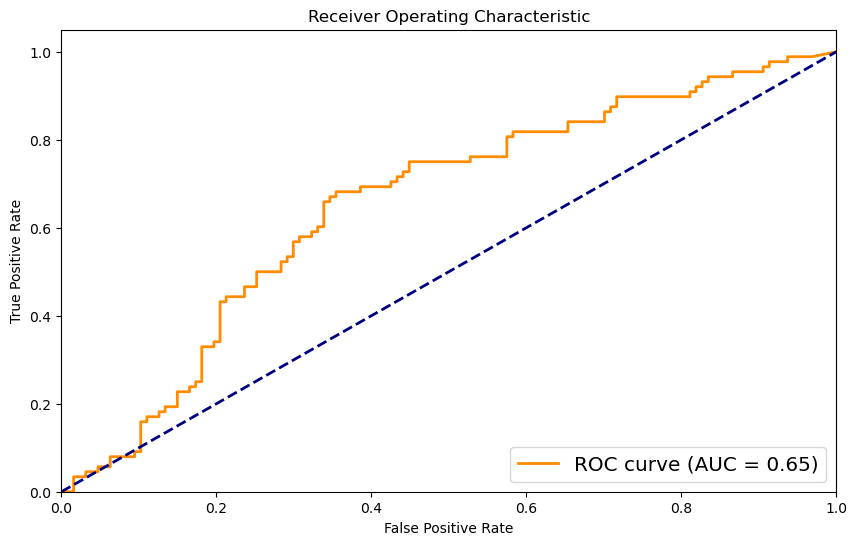

ROC curve for Support Vector Machine


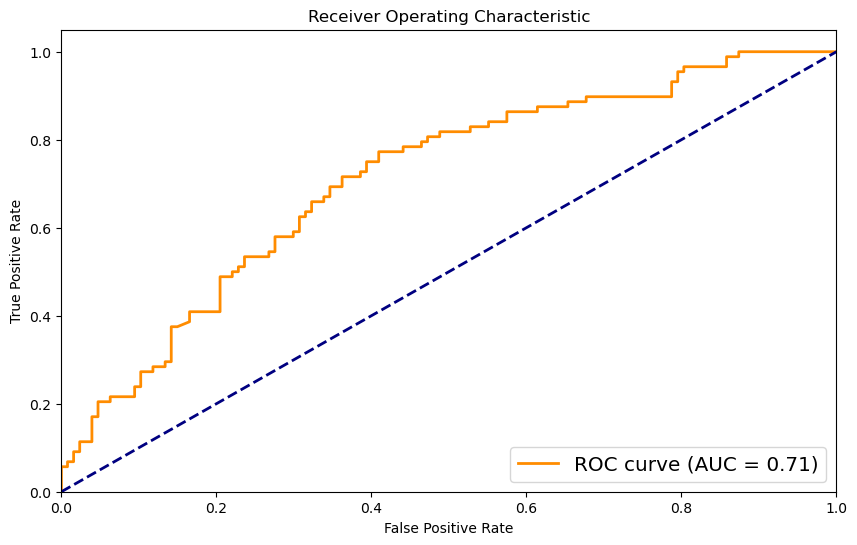

ROC curve for Decision Tree


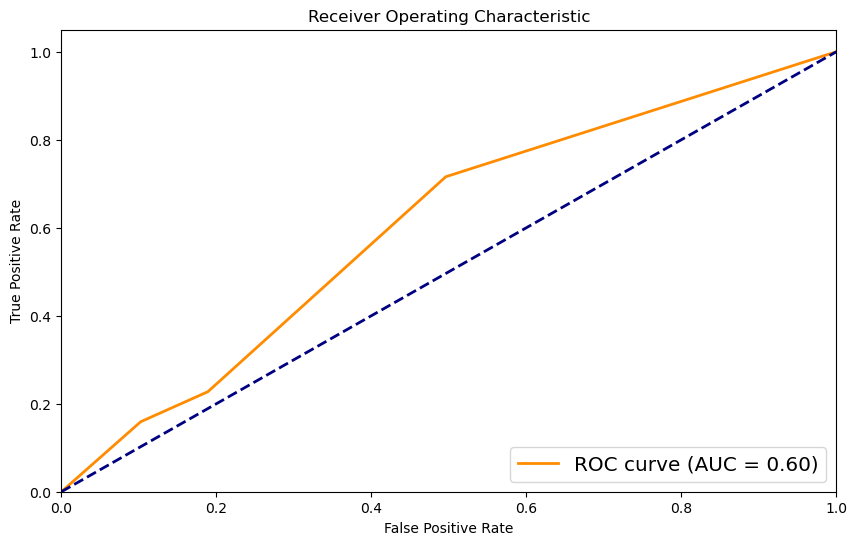

ROC curve for K-Nearest Neighbors


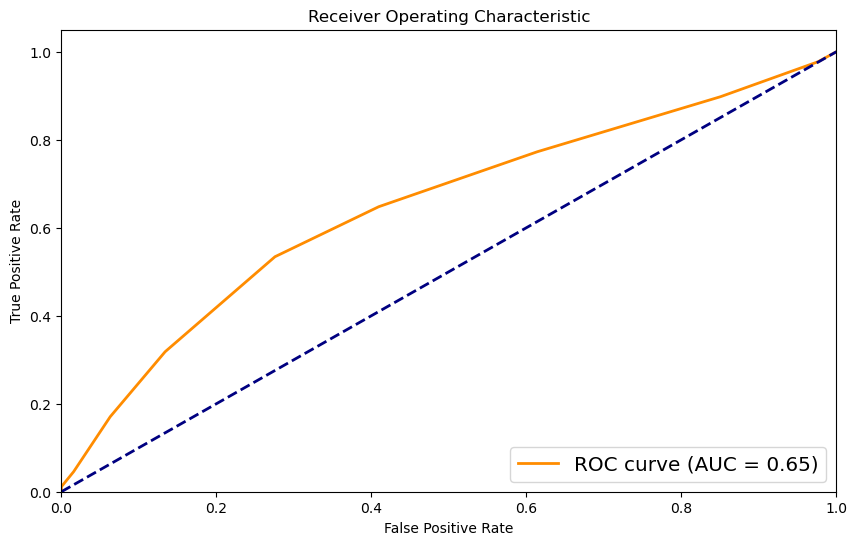

ROC curve for AdaBoost


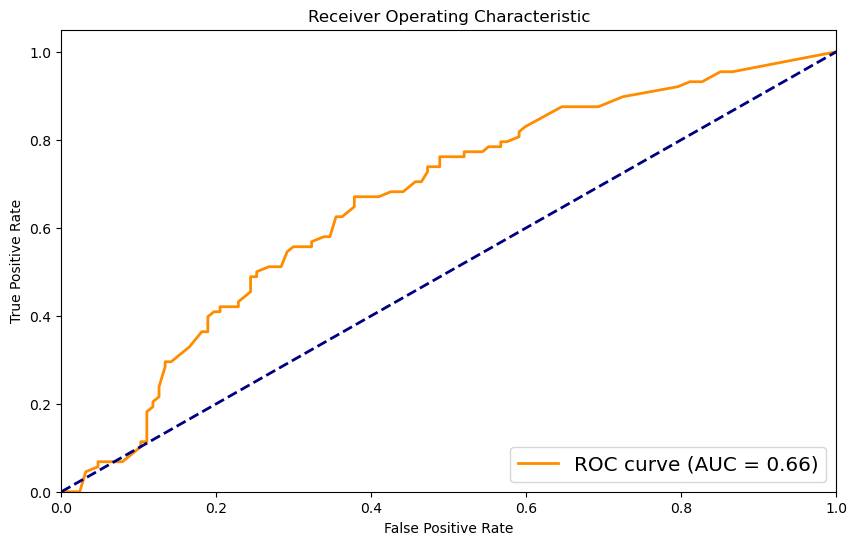

ROC curve for GradientBoosting


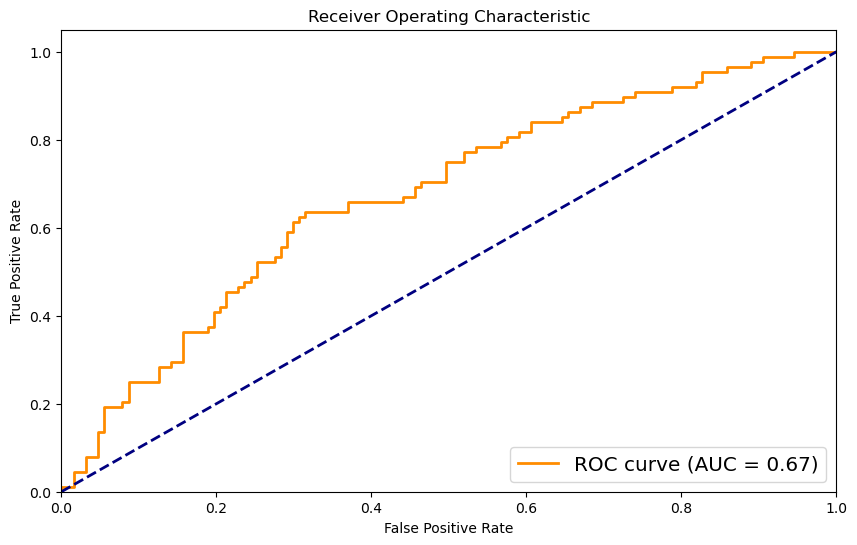

ROC curve for Naive Bayes


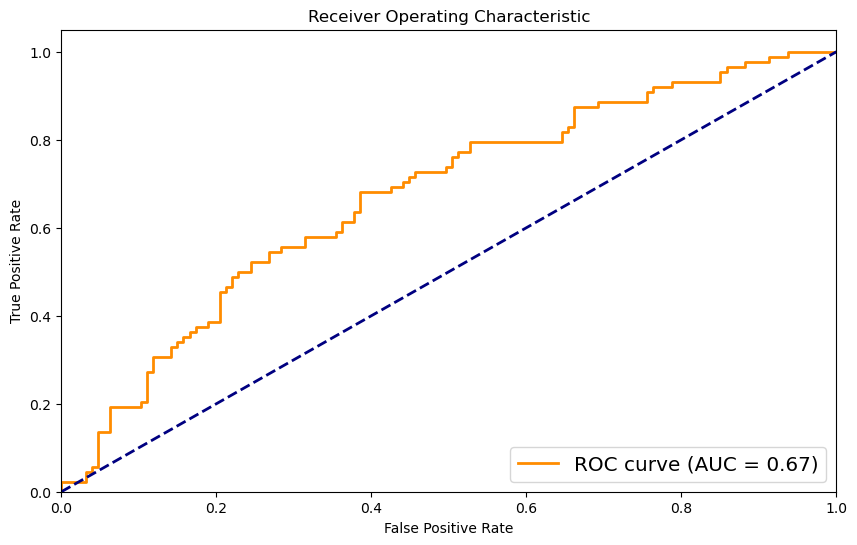

In [48]:
for name, model in final_results.items():
    print('ROC curve for', name)
    predALL_y = model.predict_proba(test_X)[:,1]
    _ = draw_roc_curve(test_y, predALL_y)

Therefore, we can observe that the best models are Support Vector Machines, AdaBoost and Naive Bayes, reaching an AUC score of 0.70, 0.66, 0.69 respectively. Now, let us check if these classifiers satisfy the proposed fairness criteria. We are going to compute the average predicted probability of men/woman non-recidivist and the average predicted probability of national/foreigner non-recidivist and compare the result to analyze the fairness of the classifier.

In [49]:
# Create empty lists to append the values
names = []
man = []
woman = []
national = []
foreigner = []

# Computations
for name,model in final_results.items():
    # Append name
    names.append(name)
    
    # Make predictions
    predPH_y = model.predict_proba(test_X)[:,1]
    
    # Man/Women
    predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
    predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]
    man.append(predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists))
    woman.append(predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists))
    
    # National/foreginer
    predPH_national_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigner_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
    national.append(predPH_national_non_recidivists.sum() / len(predPH_national_non_recidivists))
    foreigner.append(predPH_foreigner_non_recidivists.sum() / len(predPH_foreigner_non_recidivists))

# Create a dataframe to plot the results
results =  pd.DataFrame(list(zip(names,man,woman,national,foreigner)),columns=['Model Name',
                                                                                'Avg. Pred. Prob. Man',
                                                                                'Avg. Pred. Prob. Woman',
                                                                               'Avg. Pred. Prob. National',
                                                                               'Avg. Pred. Prob. Foreigner'])
# Create two more columns for a better comparison
results['Gender bias'] = abs(results['Avg. Pred. Prob. Man'] - results['Avg. Pred. Prob. Woman'])
results['Nationality bias'] = abs(results['Avg. Pred. Prob. National'] - results['Avg. Pred. Prob. Foreigner'])

# Show the results by highlighting the last two columns
# Define function to highlight the last two columns
def highlight_last_two_columns(s):
    return ['background-color: yellow' if i >= s.shape[0] - 2 else '' for i in range(s.shape[0])]

# Apply the function to the dataframe
results = results.style.apply(highlight_last_two_columns, axis=1, subset=['Gender bias', 'Nationality bias'])

# Show the results
results

,Model Name,Avg. Pred. Prob. Man,Avg. Pred. Prob. Woman,Avg. Pred. Prob. National,Avg. Pred. Prob. Foreigner,Gender bias,Nationality bias
0,Random Forest,0.412391,0.409420,0.411475,0.412356,0.002971,0.000881
1,Support Vector Machine,0.417605,0.397278,0.410665,0.418778,0.020327,0.008113
2,Decision Tree,0.405854,0.387486,0.397089,0.412143,0.018368,0.015054
3,K-Nearest Neighbors,0.375556,0.353909,0.374677,0.363144,0.021646,0.011533
4,AdaBoost,0.443715,0.436469,0.442833,0.440792,0.007246,0.002041
5,GradientBoosting,0.394655,0.322215,0.376116,0.385837,0.072439,0.009721
6,Naive Bayes,0.329753,0.151709,0.289462,0.297016,0.178044,0.007554


Remember that we have just seen that that the best models were Support Vector Machines, AdaBoost and Naive Bayes. Notice that Naive Bayes is the model with the most probabilty difference between man and woman and does not lag behind with the nationality bias. Naive Bayes is not satisfying the fairness criteria but it was one of the best classifiers!! 

On the other hand, the other models behave similarly in terms of bias, being AdaBoost the model with the lowest bias and, as we have seen before, with a good performance! Definitely, between the three models chosen in the previous exercise, taking into consideration fairness criteria and accuracy, I would choose AdaBoost instead of maybe, choosing the model with the best performance, Support Vector Machines.

Finally, we are asked for  a comparison of  several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity.


### Demographic Parity
Demographic Parity requires the outcome to be independent of the protected class. With regard to the confusion matrix, we require the Positive Rate (PR) to be the same for each segment of the protected class. 

In [50]:
# Create empty lists to append the values
names = []
man = []
woman = []
national = []
foreigner = []

# Computations
for name,model in final_results.items():
    # Append name
    names.append(name)
    
    # Make predictions
    predPH_y = model.predict_proba(test_X)[:,1]
    
    # Man/Women
    predPH_men = predPH_y[(test_X["V1_sexe_Home"]==1)]
    predPH_women = predPH_y[(test_X["V1_sexe_Dona"]==1)]
    man.append(predPH_men.sum() / len(predPH_men))
    woman.append(predPH_women.sum() / len(predPH_women))
    
    # National/foreginer
    predPH_national = predPH_y[(test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigner= predPH_y[(test_X["V2_estranger_Estranger"]==1)]
    national.append(predPH_national.sum() / len(predPH_national))
    foreigner.append(predPH_foreigner.sum() / len(predPH_foreigner))

# Create a dataframe to plot the results
results =  pd.DataFrame(list(zip(names,man,woman,national,foreigner)),columns=['Model Name',
                                                                                'Avg. Pred. Prob. Man',
                                                                                'Avg. Pred. Prob. Woman',
                                                                               'Avg. Pred. Prob. National',
                                                                               'Avg. Pred. Prob. Foreigner'])
# Create two more columns for a better comparison
results['Gender bias'] = abs(results['Avg. Pred. Prob. Man'] - results['Avg. Pred. Prob. Woman'])
results['Nationality bias'] = abs(results['Avg. Pred. Prob. National'] - results['Avg. Pred. Prob. Foreigner'])

# Show the results by highlighting the last two columns
results = results.style.apply(highlight_last_two_columns, axis=1, subset=['Gender bias', 'Nationality bias'])

# Show the results
results

,Model Name,Avg. Pred. Prob. Man,Avg. Pred. Prob. Woman,Avg. Pred. Prob. National,Avg. Pred. Prob. Foreigner,Gender bias,Nationality bias
0,Random Forest,0.421233,0.414026,0.418643,0.422482,0.007207,0.003839
1,Support Vector Machine,0.453609,0.411175,0.434575,0.466745,0.042434,0.032170
2,Decision Tree,0.432785,0.390054,0.419853,0.436476,0.042732,0.016623
3,K-Nearest Neighbors,0.425015,0.378472,0.393162,0.456209,0.046543,0.063047
4,AdaBoost,0.456627,0.442291,0.453435,0.456111,0.014336,0.002676
5,GradientBoosting,0.449922,0.326751,0.416524,0.454630,0.123171,0.038106
6,Naive Bayes,0.433902,0.179339,0.380007,0.420495,0.254563,0.040488


As before, we have a similar behaviour. Naive Bayes is the one that have the most bias in termes of Gender and  Nationality. Adaboost is again the best model in terms of this fairness criteria.

### Equal Opportunity

Equal Opportunity requires the positive outcome to be independent of the protected class, conditional on Y being an actual positive. Based on the confusion matrix, we require the True Positive Rate (TPR) to be the same for each segment of the protected class. Let us compute it.

In [51]:
# Create empty lists to append the values
names = []
man = []
woman = []
national = []
foreigner = []

# Computations
for name,model in final_results.items():
    # Append name
    names.append(name)
    
    # Make predictions
    predPH_y = model.predict_proba(test_X)[:,1]
    
    # Man/Women
    predPH_men_recidivists = predPH_y[(test_y=='Sí') & (test_X["V1_sexe_Home"]==1)]
    predPH_women_recidivists = predPH_y[(test_y=='Sí') & (test_X["V1_sexe_Dona"]==1)]
    man.append(predPH_men_recidivists.sum() / len(predPH_men_recidivists))
    woman.append(predPH_women_recidivists.sum() / len(predPH_women_recidivists))
    
    # National/foreginer
    predPH_national_recidivists = predPH_y[(test_y=='Sí') & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigner_recidivists = predPH_y[(test_y=='Sí') & (test_X["V2_estranger_Estranger"]==1)]
    national.append(predPH_national_recidivists.sum() / len(predPH_national_recidivists))
    foreigner.append(predPH_foreigner_recidivists.sum() / len(predPH_foreigner_recidivists))

# Create a dataframe to plot the results
results =  pd.DataFrame(list(zip(names,man,woman,national,foreigner)),columns=['Model Name',
                                                                                'Avg. Pred. Prob. Man',
                                                                                'Avg. Pred. Prob. Woman',
                                                                               'Avg. Pred. Prob. National',
                                                                               'Avg. Pred. Prob. Foreigner'])
# Create two more columns for a better comparison
results['Gender bias'] = abs(results['Avg. Pred. Prob. Man'] - results['Avg. Pred. Prob. Woman'])
results['Nationality bias'] = abs(results['Avg. Pred. Prob. National'] - results['Avg. Pred. Prob. Foreigner'])

# Show the results by highlighting the last two columns
results = results.style.apply(highlight_last_two_columns, axis=1, subset=['Gender bias', 'Nationality bias'])

# Show the results
results

,Model Name,Avg. Pred. Prob. Man,Avg. Pred. Prob. Woman,Avg. Pred. Prob. National,Avg. Pred. Prob. Foreigner,Gender bias,Nationality bias
0,Random Forest,0.431887,0.438898,0.432653,0.431918,0.007011,0.000735
1,Support Vector Machine,0.496987,0.486217,0.481309,0.511442,0.010770,0.030133
2,Decision Tree,0.465233,0.403919,0.464347,0.459151,0.061313,0.005196
3,K-Nearest Neighbors,0.484605,0.511111,0.429293,0.542929,0.026506,0.113636
4,AdaBoost,0.472184,0.473731,0.474158,0.470385,0.001548,0.003773
5,GradientBoosting,0.516508,0.351241,0.495503,0.518733,0.165268,0.023229
6,Naive Bayes,0.559383,0.328542,0.556979,0.535554,0.230841,0.021425


Notice that Naive Bayes remains one of the worst in terms of Gender bias. Again, AdaBoost is again the best model in terms of this fairness criteria.

### Equalized Odds

Equalised Odds requires the positive outcome to be independent of the protected class, conditional on the actual Y. Based on the confusion matrix, we require the True Positive Rate (TPR) and False Positive Rate (FPR) to be the same for each segment of the protected class. Notice that we have already check both. The TPR is just the one that we have just checked, and the FPR, is the first that we have checked.

### Conditional Demographic Parity

Conditional demographic parity requires that the predictive outcomes of a model be independent of an individual's membership in a particular demographic group, conditional on other relevant variables. This means that if two individuals, one from a protected group and one from a non-protected group, have the same relevant features (such as education, income, and credit score), the model should predict the same outcome for both of them, regardless of their demographic group membership. Let us check some relationships between gender and nationality.

In [52]:
# Create empty lists to append the values
names = []
man = []
woman = []
national = []
foreigner = []

# Computations
for name,model in final_results.items():
    # Append name
    names.append(name)
    
    # Make predictions
    predPH_y = model.predict_proba(test_X)[:,1]
    
    # Man/Women
    predPH_men_and_national = predPH_y[(test_X["V1_sexe_Home"]==1) & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_men_and_foreigner = predPH_y[(test_X["V1_sexe_Home"]==1) & (test_X["V2_estranger_Estranger"]==1)]
    predPH_woman_and_national = predPH_y[(test_X["V1_sexe_Dona"]==1) & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_woman_and_foreigner = predPH_y[(test_X["V1_sexe_Dona"]==1) & (test_X["V2_estranger_Estranger"]==1)]
    
    man.append(abs(predPH_men_and_national.sum() / len(predPH_men_and_national) - predPH_men_and_foreigner.sum() / len(predPH_men_and_foreigner)))
    woman.append(abs(predPH_woman_and_national.sum() / len(predPH_woman_and_national)-predPH_woman_and_foreigner.sum() / len(predPH_woman_and_foreigner)))
    
    # National/foreginer
    predPH_national_and_man = predPH_y[(test_X["V1_sexe_Home"]==1) & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_national_and_woman = predPH_y[(test_X["V1_sexe_Dona"]==1) & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_foreigner_and_man = predPH_y[(test_X["V1_sexe_Home"]==1) & (test_X["V2_estranger_Estranger"]==1)]
    predPH_foreigner_and_woman = predPH_y[(test_X["V1_sexe_Dona"]==1) & (test_X["V2_estranger_Estranger"]==1)]
    
    national.append(abs(predPH_national_and_man.sum() / len(predPH_national_and_man) - predPH_national_and_woman.sum() / len(predPH_national_and_woman)))
    foreigner.append(abs(predPH_foreigner_and_man.sum() / len(predPH_foreigner_and_man)-predPH_foreigner_and_woman.sum() / len(predPH_foreigner_and_woman)))
    

# Create a dataframe to plot the results
results =  pd.DataFrame(list(zip(names,man,woman,national,foreigner)),columns=['Model Name',
                                                                                'Man vs nationality bias',
                                                                                'Woman vs nationality bias',
                                                                               'National vs gender bias ',
                                                                               'Foreigner vs gender bias'])
# Show the results
results

,Model Name,Man vs nationality bias,Woman vs nationality bias,National vs gender bias,Foreigner vs gender bias
0,Random Forest,0.000873,0.021488,0.011536,0.009079
1,Support Vector Machine,0.021294,0.084221,0.051782,0.011145
2,Decision Tree,0.014370,0.005531,0.035397,0.055298
3,K-Nearest Neighbors,0.051241,0.125079,0.052063,0.021775
4,AdaBoost,0.003270,0.037092,0.023843,0.016518
5,GradientBoosting,0.028558,0.002872,0.110371,0.141800
6,Naive Bayes,0.000996,0.109307,0.278049,0.169738


As before, the behaviour is similar. Large bias with Naive Bayes meanwhile AdaBoost shows a really good performance. We can conclude the AdaBoost is a really good model for our problem, is satisfying most of the fairness criteria.

**Take home idea:**
> Even if a model is the best in terms of accuracy, it can be one of the worst in terms of fairness.

### Questions (justify you answer)

1. Is there a method that can achieve better predictive power than human experts? 

> In this particular case it is difficult to measure whether any method can achieve better predictive power than human experts. Here, the [predictions given by the human expert](#humanexpert) are given in 3 different classes (Low, Moderate, High), thus, it is complicate to divide this in Yes/No. A possible idea would be to think of Low as No and High as Yes, without taking into account the Moderate class, but it would not make sense, since the Moderate class is the one that has the most weight.

> In my opinion, I think that in this particular problem, it is highly dubious to claim that an ML model can achieve better predictive power than human experts. In this case, the human expert has information about the person that is very complicated to simplify to an amount of data. Is the machine working with the young offender every day, trying to implement a reintegration programme? Is the machine capable, with a finite amount of data, of knowing enough about the person to decide whether or not to re-offend? Nevertheless, I think that it is a very good support tool for the expert, and that a combination of both can make a better final decision.


2. Is this method better than human experts in terms of fairness?

> Below this cell, I have added the bias of the expert in terms of Nationality and Gender. Notice that the order is really similar to the AdaBoost model, which we have already seen that was the best in terms of fairness. In general, since the data is biased, our model will be biased. We have already seen that some models are much more biased than others, for instance Naive Bayes, which makes it very difficult to say that in general ML models are fairer than the human expert. Again, I think that  this is not about who is better than who, but about using both ML models and experts to improve the final decision and make it as fair as possible. Personally, I believe that the war between AI and humans is meaningless and we have to fight to be able to implement them in our daily life and improve our quality of life. 

3. Which is the most suited fairness criterium for this problem? Why?


> I think there are two possible solutions for this issue: Equalized Odds and Demographic Parity. If we can confirm that historical data is biased, then Demographic Parity might be the better option to assess fairness. For example, in the United States, there has been a long-standing history of discrimination against Black people, which can lead to biased data. In this case, using Demographic Parity can help address this issue. On the other hand, if we can confirm that the historical data is not biased, Equalized Odds may be more appropriate. Using this fariness criteria, we can require the positive outcome to be independent of the protected class, conditional on the actual Y.


4. What are your conclusion about the use of a ML model to predict recividism?

> I am going to be critical in this particular case. Using ML models to predict recividism seems to me to be very dangerous. The biggest problem I find in this particular case is that the consequences in case the model fails are immeasurable. Leaving all responsibility to an AI to decide whether the young offender will re-offend or not can cause very serious consequences, leading to the so-called abandonment (suicide). Prison reintegration programmes are very specific to each individual, it is about getting to know the individual in depth, making a complete analysis of why they are there and preparing them for reintegration into society. Although the models may work in most cases, it seems to me very dangerous to leave it entirely to an AI to make such decisions, without any specialist supervision,as the failure of the AI can lead to the death of human beings. I believe that we are not prepared to store the information necessary to make a decision of that calibre, quantifying the behaviour, thoughts, reintegration programme and progress of the prisoner is, in my view, unquantifiable today.

> With all this I would also like to comment that this can serve as a great support to the specialists of the sector, giving them an extra tool to work and improve the system, but not to substitute in this case (at least nowadays).

In [53]:
non_recidivists_expert_by_nationality['Nationality bias'] = abs(non_recidivists_expert_by_nationality['Espanyol']-
                                                                non_recidivists_expert_by_nationality['Estranger'])
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger,Nationality bias
V56_@R1_resum_risc_global_reverse,,,
Alta,0.106996,0.129771,0.022775
Baixa,0.423868,0.412214,0.011655
Moderada,0.469136,0.458015,0.011121


In [54]:
non_recidivists_expert_by_gender['Gender bias'] = abs(non_recidivists_expert_by_gender['Home']-
                                                                non_recidivists_expert_by_gender['Dona'])
non_recidivists_expert_by_gender

V1_sexe,Dona,Home,Gender bias
V56_@R1_resum_risc_global_reverse,,,
Alta,0.116667,0.114650,0.002017
Baixa,0.433333,0.417197,0.016136
Moderada,0.450000,0.468153,0.018153


# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

<div class="alert" style="padding: 20px;background-color: #2cbc85; color: white; margin-bottom: 15px; font-size:20px">
SOLUTION EXERCISE 2
</div>

Let us proceed by oversampling the minority classes (woman and foreigner). We will use a reweighting strategy, i.e, reweight the minority class in order to have the same weight than the majority class. First, let us compute the weights that we need to add for women.

In [55]:
# Create a copy of the data
train_ex2_X = train_X.copy()
test_ex2_X = test_X.copy()
train_ex2_y = train_y.copy()
test_ex2_y = test_y.copy()

In [56]:
# Compute how many men and women we have
women = train_ex2_X[train_ex2_X['V1_sexe_Dona'] == 1].shape[0]
men = train_ex2_X[train_ex2_X['V1_sexe_Home'] == 1].shape[0]
print('The total number of women in the training set is:',women)
print('The total number of men in the training set is:',men)

The total number of women in the training set is: 47
The total number of men in the training set is: 388


Notice that there are much more men than women in the dataset. Let us compute the weights to balance the dataset.

In [57]:
# Create the weights
weight = men/women
weights = train_ex2_X['V1_sexe_Dona'].apply(lambda x: weight if x==1 else 1)

We are ready to train a weighted classifier, using the weights that we have just compute. Let us check if this mitigation strategy is sufficient to guarantee fair outcomes.

In [58]:
# Train the weighted model
clf = LogisticRegression(random_state = 42, solver='liblinear')
clf.fit(train_ex2_X.drop(['V1_sexe_Dona', 'V1_sexe_Home'],axis=1), train_ex2_y, sample_weight = weights.values )

LogisticRegression(random_state=42, solver='liblinear')

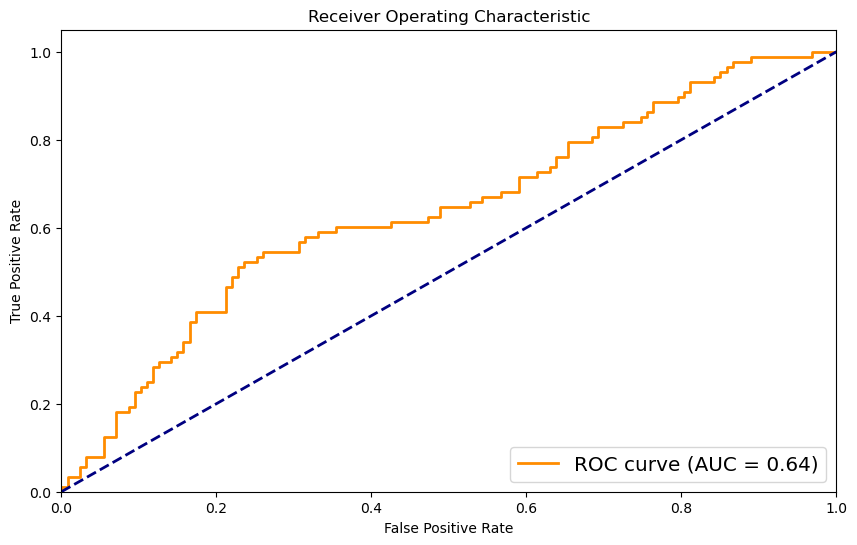

In [59]:
# Prediction and plot the roc curve
predPH_y = clf.predict_proba(test_ex2_X.drop(['V1_sexe_Dona', 'V1_sexe_Home'],axis=1))[:,1]
_ = draw_roc_curve(test_ex2_y, predPH_y)

Let us compute again the fairness of the weighted classifier. To check the baseline and compare results, [click here](#baselinefair1).

In [60]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.31
Average predicted probability of women non-recidivist: 0.30


Now, let us do the same computation but working with foreigners and nationals, to check if we can increase the fairness value using weights. Let us repeat the computations!

In [61]:
# Compute how many foreigners and nationals we have.
foreigner = train_ex2_X[train_ex2_X['V2_estranger_Estranger'] == 1].shape[0]
national = train_ex2_X[train_ex2_X['V2_estranger_Espanyol'] == 1].shape[0]
print('The total number of foreigners in the training set is:',foreigner)
print('The total number of nationals in the training set is:',national)

The total number of foreigners in the training set is: 181
The total number of nationals in the training set is: 254


In [62]:
# Create the weights to balance the dataset
weight = national/foreigner
weights = train_ex2_X['V2_estranger_Estranger'].apply(lambda x: weight if x==1 else 1)

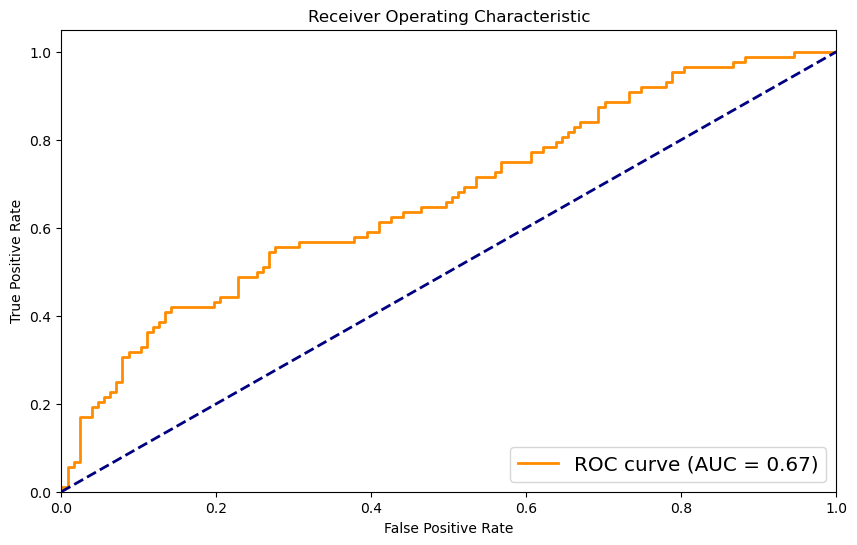

In [63]:
# Train the weighted model
clf = LogisticRegression(random_state = 42, solver='liblinear')
clf.fit(train_ex2_X.drop(['V2_estranger_Espanyol', 'V2_estranger_Espanyol'],axis=1), train_ex2_y, sample_weight = weights.values )
# Prediction and plot the roc curve
predPH_y = clf.predict_proba(test_ex2_X.drop(['V2_estranger_Espanyol', 'V2_estranger_Espanyol'],axis=1))[:,1]
_ = draw_roc_curve(test_ex2_y, predPH_y)

Let us compute again the fairness of the weighted classifier. To check the baseline and compare results, [click here](#baselinefair1).

In [64]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.32
Average predicted probability of foreigner non-recidivist: 0.39


### Questions (justify you answer)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

> Notice that, in terms of gender, the bias before the mitigation strategy was about 0.26, while now, after the mitigation strategy, we have reduced the bias to 0.02. In termes of nationality, the bias before the mitigation strategy was about 0.13, while now, afther the mitigation strategy, we have reduced the bias to 0.06. This is a huge improvement!! Observe that this method it is not sufficient to guarantee perfect fair outcomes, as we can still observe a bit of bias, but is more than enough to give us a starting point to work from. However, we can conclude that the method produces much fairer outcomes than previously.

> In general it is difficult to completely mitigate the bias using these strategies since we are not ensuring minority class variability, which will be necessary to guarantee fair oucomes. Actually, this is always a problem when performing a oversampling method, we can not ensure real variability of the minority class.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

<div class="alert" style="padding: 20px;background-color: #2cbc85; color: white; margin-bottom: 15px; font-size:20px">
SOLUTION EXERCISE 3
</div>

Let us apply explainability models to (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). Since the in (i) and (ii) we only have one feature, we will perform a permutation test to see the importance of this feature in the prediction.

In [65]:
# Create a copy of the data
train_ex3_X = train.copy()
test_ex3_X = test.copy()
train_ex3_y = train_y.copy()
test_ex3_y = test_y.copy()

### Human risk assessment score

Let us perform a LabelEncoder to this feature, taking into account that: low=0, moderate=1, high=1. Thus, we will be able to perform a permutation test to the classifier.

In [66]:
from sklearn.metrics import accuracy_score

# Prepare the training and test set
train_XX = train_ex3_X['V56_@R1_resum_risc_global_reverse'].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)
test_XX = test_ex3_X['V56_@R1_resum_risc_global_reverse'].replace('Baixa',0).replace('Moderada',1).replace('Alta',2)

# Fit a logistic regression model on the training data
model = LogisticRegression(random_state=42, solver='liblinear').fit(train_XX.values.reshape(-1,1), train_ex3_y)

# Compute the accuracy on the test data
test_acc = accuracy_score(test_ex3_y, model.predict(test_XX.values.reshape(-1,1)))

# Permute the feature and compute the accuracy on the test data
permuted_test_acc = []
for i in range(1000):
    # Permute the feature values in the test data
    permuted_test_X = test_XX.sample(frac=1, random_state=i).reset_index(drop=True)
    permuted_test_X = pd.DataFrame({'V56_@R1_resum_risc_global_reverse': permuted_test_X})
    permuted_test_X_final = test.copy()
    permuted_test_X_final = permuted_test_X

    # Compute the accuracy on the permuted test data
    permuted_test_acc.append(accuracy_score(test_y, model.predict(permuted_test_X_final.values.reshape(-1,1))))

# Compute the feature importance
fi = np.mean(np.array(permuted_test_acc)) / test_acc
print('Test original accuracy:', test_acc)
print('Average accuracy of the permutation test:',np.mean(np.array(permuted_test_acc)))
print("Feature importance:", fi)

Test original accuracy: 0.6837209302325581
Average accuracy of the permutation test: 0.5514325581395348
Feature importance: 0.8065170068027211


>We can conclude that this feature is important for the classification. The original score, wtithout permuting the values, reaches a value much higher than the average among the accuracies of the swapped values. Morever, the feature importance value is also high. We can conclude that this feature is important!

Another way of interpreting this exercise is to train a model with the human risk assessment score as a target. We will use the rest of the features in the training set and we will perform a permutation test to see which are the most important ones. For this exercise, I will use the library `eli5`, which will allow me to compute a permutation test in a simpler way.

In [67]:
import eli5
from eli5.sklearn import PermutationImportance

# Create the target in the traning and test set
target_train = train_ex3_X['V56_@R1_resum_risc_global_reverse']
target_test = test_ex3_X['V56_@R1_resum_risc_global_reverse']

# Fit the model
model = LogisticRegression(random_state=42, solver='liblinear').fit(train_X, target_train)

# Apply permutation test
perm = PermutationImportance(model,random_state=42).fit(test_X, target_test)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

2023-05-07 17:29:12.503704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Weight,Feature
0.0205 ± 0.0192,V79_@15_manca_suport_personal_social_Baix
0.0167 ± 0.0095,V80_@16_entorn_marginal_Moderat
0.0158 ± 0.0112,V72_@8_delinquencia_pares_Moderat
0.0149 ± 0.0160,V87_@23_baixa_colaboracio_intervencions_Baix
0.0140 ± 0.0059,V77_@13_estrés_incapacitat_enfrontar_dificultats_Moderat
0.0130 ± 0.0259,V81_@17_actitud_negatives_Baix
0.0121 ± 0.0151,V88_@24_baix_compromis_escolar_laboral_Moderat
0.0112 ± 0.0046,V79_@15_manca_suport_personal_social_Moderat
0.0112 ± 0.0074,V93_@P5_fort_compromis_escola_treball_Present
0.0102 ± 0.0070,V75_@11_delinquencia_grup_iguals_Moderat


> Here we can find the most important features to our model in order to classify our target. The first number in each row (before the plus and minus sign) represents the amount of model performance deterioration that happened as a result of randomly shuffling the feature. Notice that, neither gender nor nationality is in the top ten most important features! This may mean that the human risk assessment score is fair.

### SAVRY baseline model

Let us perform the same computation but now using the SAVRY total score.

In [68]:
# Prepare the training and test set
train_XX = train_ex3_X['V60_SAVRY_total_score']
test_XX = test_ex3_X['V60_SAVRY_total_score']

# Fit a logistic regression model on the training data
model = LogisticRegression(random_state=42, solver='liblinear').fit(train_XX.values.reshape(-1,1), train_ex3_y)

# Compute the accuracy on the test data
test_acc = accuracy_score(test_ex3_y, model.predict(test_XX.values.reshape(-1,1)))

# Permute the feature and compute the accuracy on the test data
permuted_test_acc = []
for i in range(1000):
    # Permute the feature values in the test data
    permuted_test_X = test_XX.sample(frac=1, random_state=i).reset_index(drop=True)
    permuted_test_X = pd.DataFrame({'V60_SAVRY_total_score': permuted_test_X})
    permuted_test_X_final = test.copy()
    permuted_test_X_final = permuted_test_X

    # Compute the accuracy on the permuted test data
    permuted_test_acc.append(accuracy_score(test_y, model.predict(permuted_test_X_final.values.reshape(-1,1))))

# Compute the feature importance
fi = np.mean(np.array(permuted_test_acc)) / test_acc
print('Test accuracy:', test_acc)
print('Average accuracy of the permutation test:',np.mean(np.array(permuted_test_acc)))
print("Feature importance:", fi)

Test accuracy: 0.6186046511627907
Average accuracy of the permutation test: 0.5471627906976745
Feature importance: 0.8845112781954888


>We can conclude that this feature is important for the classification. The original score, wtithout permuting the values, reaches a value much higher than the average among the accuracies of the swapped values. Morever, the feature importance value is also high. We can conclude that this feature is important!

Again, we can follow the other interpretation to solve this problem. Let us set the SAVRY score as a target and perform a permutation test to the others features.

In [69]:
# Create the target in the traning and test set
target_train = train_ex3_X['V60_SAVRY_total_score']
target_test = test_ex3_X['V60_SAVRY_total_score']

# Fit the model
model = LogisticRegression(random_state=42, solver='liblinear').fit(train_X, target_train)

# Apply permutation test
perm = PermutationImportance(model,random_state=42).fit(test_X, target_test)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

Weight,Feature
0.0074 ± 0.0046,V1_sexe_Home
0.0074 ± 0.0126,V79_@15_manca_suport_personal_social_Baix
0.0074 ± 0.0112,V88_@24_baix_compromis_escolar_laboral_Alt
0.0065 ± 0.0151,V82_@18_assumpcio_riscos_impulsivitat_Moderat
0.0065 ± 0.0151,V78_@14_escassa_habilitat_pares_educar_Alt
0.0065 ± 0.0240,V20_nombre_antecedents
0.0047 ± 0.0059,V1_sexe_Dona
0.0047 ± 0.0059,V71_@7_historia_maltracte_infantil_Alt
0.0047 ± 0.0059,V68_@4_fracas_intervencions_anteriors_Moderat
0.0047 ± 0.0118,V83_@19_problemes_consum_toxics_Alt


> Here we can find the most important features to our model in order to classify our target. The first number in each row (before the plus and minus sign) represents the amount of model performance deterioration that happened as a result of randomly shuffling the feature. Again, neither gender nor nationality is in the top ten most important features! This may mean that the SAVRY score is fair.

### To the best ML model

Recall that our best ML model was an AdaBoost classifier. Let us retrain the model to compute the feature importance. Moreover, we will check if the model predict the same feature importance before and after the mitigation strategy computed in Exercise 2.

In [70]:
# Fit the AdaBoost model and compute the feature importance

# Find the model and fit
model = final_results['AdaBoost']
model.fit(train_X, train_y)

# Compute feature importance
importance = model.feature_importances_

# Create a dict with column names and sort the features
feature_dict = dict(zip(train_X.columns, importance))
top_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:10]

In [71]:
# Visualization of the top 10 features
df_importance = pd.DataFrame(top_features, columns=['FEATURES', 'IMPORTANCE'])
df_importance

,FEATURES,IMPORTANCE
0,V20_nombre_antecedents,0.38
1,V79_@15_manca_suport_personal_social_Alt,0.14
2,V90_@P2_suport_social_fort_Absent,0.11
3,V90_@P2_suport_social_fort_Present,0.10
4,V8_edat_fet,0.08
5,V69_@5_intents_autolesio_suicidi_anteriors_Mod...,0.07
6,V75_@11_delinquencia_grup_iguals_Baix,0.06
7,V93_@P5_fort_compromis_escola_treball_Absent,0.04
8,V81_@17_actitud_negatives_Baix,0.01
9,V93_@P5_fort_compromis_escola_treball_Present,0.01


Instead of computing the feature importance of the tree, we can repeat the same strategy as before and compute a permutation test. Let us observe if we get similar results:

In [72]:
# Fit the model
model = final_results['AdaBoost']
model.fit(train_X, train_y)

# Apply permutation test
perm = PermutationImportance(model,random_state=42).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

Weight,Feature
0.0233 ± 0.0118,V90_@P2_suport_social_fort_Absent
0.0223 ± 0.0285,V20_nombre_antecedents
0.0195 ± 0.0215,V90_@P2_suport_social_fort_Present
0.0102 ± 0.0160,V79_@15_manca_suport_personal_social_Alt
0.0065 ± 0.0126,V93_@P5_fort_compromis_escola_treball_Absent
0.0056 ± 0.0180,V75_@11_delinquencia_grup_iguals_Baix
0.0047 ± 0.0059,V8_edat_fet
0.0009 ± 0.0070,V81_@17_actitud_negatives_Baix
0 ± 0.0000,V74_@10_baix_rendiment_escola_Alt
0 ± 0.0000,V70_@6_exposicio_violencia_llar_Alt


> We have just shown the top ten most important features for our best classifier performing both a feature importance and a permutation test. Notice that the age and the background information are really important, in both tests, are in the top ten most important features. In comparison with the SAVRY and the human risk assessment score, we can observe that now, gender and nationality are in the top ten most important features, while they were not before. We can conclude that the ML model is less fair than SAVRY and the human risk assessment score

To finish the assignment we are asked to recompute this feature importance after the application of the equalized base rates (EBR) mitigation stratgey. Let us code it! First, we will show the feature importance for the weighted model using men/women and then, for foreigner/national. For simplification, we will only work with the feature importance of the tree, but it will be the same using a permutation test.

In [73]:
# Fit the AdaBoost model and compute the feature importance for MEN/WOMEN

# Find the weights
women = train_ex2_X[train_ex2_X['V1_sexe_Dona'] == 1].shape[0]
men = train_ex2_X[train_ex2_X['V1_sexe_Home'] == 1].shape[0]

# Create the weights
weight = men/women
weights = train_ex2_X['V1_sexe_Dona'].apply(lambda x: weight if x==1 else 1)

# Train the weighted model
model.fit(train_ex2_X.drop(['V1_sexe_Dona', 'V1_sexe_Home'],axis=1), train_ex2_y, sample_weight = weights.values )

# Compute feature importance
importance = model.feature_importances_

# Create a dict with column names and sort the features
feature_dict = dict(zip(train_ex2_X.drop(['V1_sexe_Dona', 'V1_sexe_Home'],axis=1).columns, importance))
top_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Visualization of the top 10 features
df_importance = pd.DataFrame(top_features, columns=['FEATURES', 'IMPORTANCE'])
df_importance

,FEATURES,IMPORTANCE
0,V79_@15_manca_suport_personal_social_Alt,0.51
1,V20_nombre_antecedents,0.21
2,V80_@16_entorn_marginal_Alt,0.09
3,V90_@P2_suport_social_fort_Absent,0.06
4,V90_@P2_suport_social_fort_Present,0.04
5,V93_@P5_fort_compromis_escola_treball_Present,0.04
6,V74_@10_baix_rendiment_escola_Alt,0.03
7,V93_@P5_fort_compromis_escola_treball_Absent,0.02
8,V8_edat_fet,0.00
9,V2_estranger_Espanyol,0.00


In [74]:
# Fit the AdaBoost model and compute the feature importance for FOREIGNER/NATIONAL

# Find the weights
foreigner = train_ex2_X[train_ex2_X['V2_estranger_Estranger'] == 1].shape[0]
national = train_ex2_X[train_ex2_X['V2_estranger_Espanyol'] == 1].shape[0]

# Create the weights
weight = national/foreigner
weights = train_ex2_X['V2_estranger_Estranger'].apply(lambda x: weight if x==1 else 1)

# Train the weighted model
model.fit(train_ex2_X.drop(['V2_estranger_Estranger', 'V2_estranger_Espanyol'],axis=1), train_ex2_y, sample_weight = weights.values )

# Compute feature importance
importance = model.feature_importances_

# Create a dict with column names and sort the features
feature_dict = dict(zip(train_ex2_X.drop(['V2_estranger_Estranger', 'V2_estranger_Espanyol'],axis=1).columns, importance))
top_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Visualization of the top 10 features
df_importance = pd.DataFrame(top_features, columns=['FEATURES', 'IMPORTANCE'])
df_importance

,FEATURES,IMPORTANCE
0,V20_nombre_antecedents,0.34
1,V79_@15_manca_suport_personal_social_Alt,0.22
2,V8_edat_fet,0.10
3,V75_@11_delinquencia_grup_iguals_Baix,0.09
4,V90_@P2_suport_social_fort_Absent,0.07
5,V69_@5_intents_autolesio_suicidi_anteriors_Mod...,0.06
6,V93_@P5_fort_compromis_escola_treball_Present,0.05
7,V93_@P5_fort_compromis_escola_treball_Absent,0.04
8,V90_@P2_suport_social_fort_Present,0.03
9,V1_sexe_Dona,0.00


> The last two dataframes are the top ten most important features for our classifier after the mitigation strategy. No much difference is provided, background information and age are again the most important features for the classification. Nevertheless, after the mitigation strategy, we have achieved a much fairer model. 
